<a href="https://colab.research.google.com/github/svetaU/hmc/blob/main/model_w_auto_grad_HMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import scipy.stats as st
import math
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, writers

# HMC

In [2]:
def leapfrog(q, p, dUdq, num_steps, step_size, random_step=False,m=None):
  if random_step:
    step_size = np.random.uniform(step_size*0.8,step_size*1.2,1)
  if m is None:
    m = np.ones(len(p))
  q, p = np.copy(q), np.copy(p)
  p -= step_size * dUdq(q) / 2.0  
  leap_path = [np.copy(q)]
  for _ in range(num_steps - 1):
      q += step_size * p/m  
      p -= step_size * dUdq(q) 
      leap_path.append(np.copy(q))
  q += step_size * p/m  
  p -= step_size * dUdq(q) / 2.0
  leap_path.append(np.copy(q)) 
  return (q,-p,leap_path)


In [3]:
def hamiltonian_monte_carlo(U, grad_U, current_position, steps=1, delta_t=0.5, change_step = False, masses = None):
  q = np.copy(current_position)
  p = np.random.normal(0.0,1.0,len(q)) 
  current_momentum = np.copy(p)
  if masses is None:
    masses = np.ones(len(p))
  q, p, path = leapfrog(q,p,grad_U,steps,delta_t,change_step, masses)
  current_U = U(current_position)
  current_K = sum(current_momentum*current_momentum/masses) / 2
  proposed_U = U(q)
  proposed_K = sum(p*p/masses) / 2
  if (np.log(np.random.rand()) < (current_U-proposed_U+current_K-proposed_K)):
    return (q,proposed_U,1,path) # accept
  else:
    return (current_position, current_U,0,None) # reject

# Test
Fit parameters of bivariate gaussian ($\mu_X$,$\mu_Y$,$\sigma_X$, $\sigma_Y$, and $\rho$) 
$$ 
p(x,y) =
      \frac{1}{2 \pi  \sigma_X \sigma_Y \sqrt{1-\rho^2}}
      \exp
        \left( -\frac{1}{2(1-\rho^2)}\left[
          \left(\frac{x-\mu_X}{\sigma_X}\right)^2 -
          2\rho\left(\frac{x-\mu_X}{\sigma_X}\right)\left(\frac{y-\mu_Y}{\sigma_Y}\right) +
          \left(\frac{y-\mu_Y}{\sigma_Y}\right)^2 
        \right]
       \right)
$$
 via Bayesian approach with priors in the general form of
 $$
 \pi_{ab}(\mu_X,\mu_Y,\sigma_X,\sigma_Y,\rho)=\frac{1}{\sigma_X^{3-a}\sigma_Y^{2-b}\left(1-\rho^2\right )^{2-b/2}}
 $$
 .

In [19]:
class FitBivariatNormal():

  def __init__(self, **kwargs):
    self.data = []

  def set_data(self,data):
    self.data = np.copy(data)

  def log_likelihood(self,params): # -log(p)
    m1 = params[0]
    m2 = params[1]
    s1 = params[2]
    s2 = params[3]
    corr = params[4]
    y = 0
    for x in self.data:
      y = y + ( (x[0] - m1)**2/s1/s1 + (x[1] - m2)**2/s2/s2 - 2.0*corr*(x[0] - m1)*(x[1] - m2)/s2/s2 )/2.0/(1-corr*corr) \
      + math.log(s1) + math.log(s2) + 0.5*math.log(1. - corr*corr)
    return y   

  def tf_log_likelihood(self,params): # -log(p)
    y = 0
    for x in self.data:
      y = y + tf.math.divide(( tf.math.divide(tf.math.square(x[0] - params[0]),tf.math.square(params[2])) \
               + tf.math.divide(tf.math.square(x[1] - params[1]),tf.math.square(params[3])) \
               - tf.math.divide(2.0*params[4]*tf.math.multiply((x[0] - params[0]),(x[1] - params[1])),tf.math.multiply(params[2],params[3])) ) \
      ,tf.math.multiply(2.0,(1-tf.math.square(params[4])))) \
      + tf.math.log(params[2]) + tf.math.log(params[3]) + 0.5*tf.math.log(1. - tf.math.square(params[4]))
    return y 

  def log_priors(self,params): # -log(\pi)
    a = 1
    b = 0
    m1 = params[0]
    m2 = params[1]
    s1 = params[2]
    s2 = params[3]
    corr = params[4]
    p_params = (3. - a)*s1 + (2. - b)*s2 + (2. - 0.5*b)*(1. - corr*corr)
    return p_params

  def tf_log_priors(self,params): # -log(\pi)
    a = 1
    b = 0
    hyp_params = tf.constant([0.,0.,(3. - a),(2. - b),(2. - 0.5*b)])
    p_params = tf.math.multiply(hyp_params,params)
    y = tf.reduce_sum(p_params) - tf.math.multiply(hyp_params[4],params[4]) + tf.math.multiply(hyp_params[4],(1. - tf.math.square(params[4])))
    return y

  def log_likelihood_grad(self,params): 
    params = tf.convert_to_tensor(params, dtype=tf.float32)
    with tf.GradientTape() as tape:
      tape.watch(params)
      y = self.tf_log_likelihood(params)
    return tape.gradient(y,params).numpy()

  def log_priors_grad(self, params):
    params = tf.convert_to_tensor(params, dtype=tf.float32)
    with tf.GradientTape() as tape:
      tape.watch(params)
      y = self.tf_log_priors(params)
    return tape.gradient(y,params).numpy()

  def log_prob(self, params):
    return self.log_likelihood(params) + self.log_priors(params)

  def log_prob_grad(self,params):
    return self.log_likelihood_grad(params) + self.log_priors_grad(params)


# Fit parameters

In [5]:
def fit_bivariate_w_hmc():
  target_mean = [2.,3.]
  target_cov = [[2.5,0.4],[0.4,1.6]] 
  sigma1 = round(math.sqrt(target_cov[0][0]),2)
  sigma2 = round(math.sqrt(target_cov[1][1]),2)
  rho = round(target_cov[0][1]/sigma1/sigma2,2)
  sample_size = 100
  data_sample = np.random.multivariate_normal(target_mean,target_cov,size=sample_size)
  m = [2.,2.,10.,10., 100.]
  x_limits = (target_mean[0] - target_cov[0][0]*1.,target_mean[0] + target_cov[0][0]*1.)
  y_limits = (target_mean[1] - target_cov[1][1]*1.,target_mean[1] + target_cov[1][1]*1.)
  model_fit = FitBivariatNormal()
  model_fit.set_data(data_sample)
  points_to_sim = 10
  l_steps = 10
  burn = 0
  hmc_steps = np.asarray(range(points_to_sim+1-burn))
  sim_dots = []
  q = np.asarray([0.,0.,1.,1.,0.])
  sim_dots.append(q)
  paths = []
  accept_rate = 0
  for i in range(points_to_sim):
    q, orbit,accept,l_path = hamiltonian_monte_carlo(model_fit.log_prob,model_fit.log_prob_grad,q,steps=l_steps, \
                                                     delta_t=0.01,masses = m)
    sim_dots.append(q)
    paths.append(l_path)
    accept_rate = accept_rate + accept
  fig = plt.figure(figsize = (5,5))
  axes = fig.add_subplot(1,1,1)
  #axes.set_xlim(x_limits[0],x_limits[1])
  #axes.set_ylim(y_limits[0],y_limits[1])
  for point in sim_dots[burn:points_to_sim]:
    plt.scatter(point[0],point[1],c='red',s=30)
  for path in paths[burn:points_to_sim]:
    if path is not None:
      plt.plot(np.asarray(path)[:,0],np.asarray(path)[:,1], c='black')
  plt.title("Bivariate means")
  plt.xlabel("mu1")
  plt.ylabel("mu2")  
  plt.show()
  print("Acceptance rate " + str(accept_rate/points_to_sim))
  print("First mean " + str(np.mean(np.asarray(sim_dots)[burn:,0])) + " (expected " + str(target_mean[0]) + ")")
  print("Second mean " + str(np.mean(np.asarray(sim_dots)[burn:,1])) + " (expected " + str(target_mean[1]) + ")")
  print("First sigma " + str(np.mean(np.asarray(sim_dots)[burn:,2])) + " (expected " + str(sigma1) + ")")
  print("Second sigma " + str(np.mean(np.asarray(sim_dots)[burn:,3])) + " (expected " + str(sigma2) + ")")
  print("Rho " + str(np.mean(np.asarray(sim_dots)[burn:,4])) + " (expected " + str(rho) + ")")
  
  plt.scatter(hmc_steps,np.asarray(sim_dots)[burn:,0])
  plt.title("Trace plot mu1")
  plt.xlabel("iteration")
  plt.ylabel("mu1")  
  plt.show()
  plt.scatter(hmc_steps,np.asarray(sim_dots)[burn:,1])
  plt.title("Trace plot mu2")
  plt.xlabel("iteration")
  plt.ylabel("mu2")  
  plt.show()
  plt.scatter(hmc_steps,np.asarray(sim_dots)[burn:,2])
  plt.title("Trace plot sigma1")
  plt.xlabel("iteration")
  plt.ylabel("sigma1")  
  plt.show()
  plt.scatter(hmc_steps,np.asarray(sim_dots)[burn:,3])
  plt.title("Trace plot sigma2")
  plt.xlabel("iteration")
  plt.ylabel("sigma2")  
  plt.show()
  plt.scatter(hmc_steps,np.asarray(sim_dots)[burn:,4])
  plt.title("Trace plot rho")
  plt.xlabel("iteration")
  plt.ylabel("rho")  
  plt.show()
  

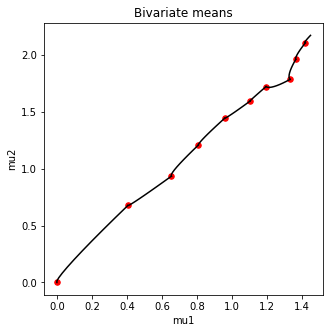

Acceptance rate 1.0
First mean 0.9712690429688006 (expected 2.0)
Second mean 1.420605931135066 (expected 3.0)
First sigma 1.3941969013620263 (expected 1.58)
Second sigma 1.4432975597930329 (expected 1.26)
Rho 0.04970617179797132 (expected 0.2)


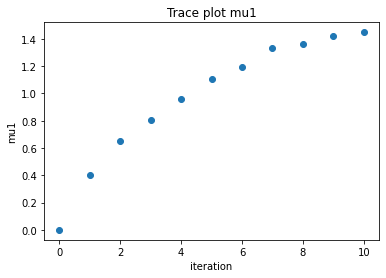

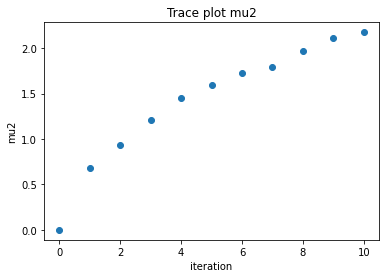

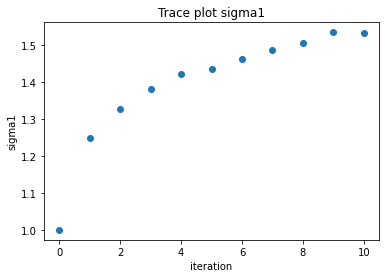

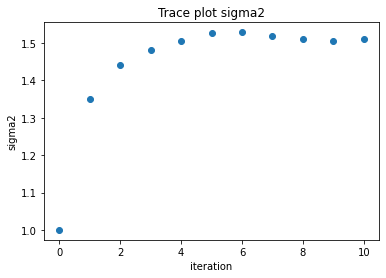

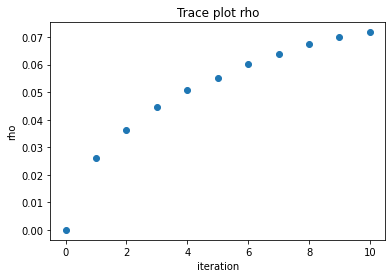

In [20]:
fit_bivariate_w_hmc()